In [4]:
!pip install ipykernel transformer_lens plotly 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 KB 648.1 kB/s eta 0:00:00a 0:00:01


In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [ ]:
import transformer_lens
import torch
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
# Import stuff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px

import wandb
from jaxtyping import Float
from functools import partial
import numpy as np

from tqdm import tqdm
from typing import List, Dict

# Initialize model config

In [ ]:
config = transformer_lens.HookedTransformerConfig(
    n_layers=4,
    d_model=1024,
    n_ctx=1024,
    d_head=1024,
    n_heads=1,
    d_mlp=4*1024,
    d_vocab=-1, # Automatically set from the tokenizer's vocab size
    act_fn="gelu",
    tokenizer_name="meta-llama/Llama-3.2-1B-Instruct",
    normalization_type="LN",
    positional_embedding_type="rotary",
)
model = transformer_lens.HookedTransformer(config)
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      

# Train model

In [ ]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../generators")
sys.path.insert(0, "generators")


from generators.string_reversal import StringReversalGenerator
import transformers
import itertools

train_batch_size = 64
eval_batch_size = 64

ID_data_generator = StringReversalGenerator(tokenizer=model.tokenizer,
                                       seed=1,
                                       length=(1,100),
                                       )

OOD_data_generator = StringReversalGenerator(tokenizer=model.tokenizer,
                                       seed=1,
                                       length=(200,300),
                                       )
train_samples = itertools.islice(ID_data_generator.generate_samples(), 100000)
train_dataset = ID_data_generator.generate_dataset(train_samples)
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size)

val_ID_samples = itertools.islice(ID_data_generator.generate_samples(), 100)
val_ID_dataset = ID_data_generator.generate_dataset(val_ID_samples)
val_ID_data_loader = DataLoader(val_ID_dataset, batch_size=train_batch_size)

val_OOD_samples = itertools.islice(OOD_data_generator.generate_samples(), 100)
val_OOD_dataset = ID_data_generator.generate_dataset(val_OOD_samples)
val_OOD_data_loader = DataLoader(val_OOD_dataset, batch_size=train_batch_size)

test_samples = itertools.islice(OOD_data_generator.generate_samples(), 1000)
test_dataset = ID_data_generator.generate_dataset(test_samples)
test_data_loader = DataLoader(test_dataset, batch_size=eval_batch_size)



Generated dataset with 100000 samples; batched input shape: torch.Size([100000, 202])
Generated dataset with 100 samples; batched input shape: torch.Size([100, 202])
Generated dataset with 100 samples; batched input shape: torch.Size([100, 602])
Generated dataset with 1000 samples; batched input shape: torch.Size([1000, 602])


In [ ]:
import pickle
with open("training_data.pkl", "wb") as f:
    pickle.dump((train_data_loader, val_ID_data_loader, val_OOD_data_loader, test_data_loader), f)

In [ ]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../generators")
sys.path.insert(0, "generators")


from generators.string_reversal import StringReversalGenerator
import transformers
import itertools
import pickle
with open("training_data.pkl", "rb") as f:
    train_data_loader, val_ID_data_loader, val_OOD_data_loader, test_data_loader = pickle.load(f)

In [ ]:
def train(model: torch.nn.Module, 
          train_data_loader: DataLoader, 
          val_data_loaders: List[DataLoader], 
          batch_size=16,
          learning_rate=1e-5,
          ignore_index=-100,
          epochs=3,
          device="cuda",
          save_checkpoint=True,
          checkpoint_filepath="model_hooked.weights"):
    if batch_size >= 64 and hasattr(model, "gradien
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=ignore_index)
    model.train()
    step = 0
    for epoch in range(epochs):
        total_loss = 0.0
        train_iterator = tqdm(train_data_loader)
        for batch in train_iterator:
            input_ids = batch["input_ids"].to(device)
            labels = batch["target_ids"].to(device)
            #attn_labels = batch["attn_labels"]
            #texts = batch["texts"]
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()
            step += 1
            total_loss += loss.item()
            train_iterator.set_postfix(loss=loss.item())
            if step % 10 == 0:
                wandb.log({"train_loss": loss.item()})
                grad_norm = np.sqrt(sum([torch.norm(p.grad.detach().cpu())**2 for p in model.parameters()]))
                wandb.log({"grad_norm": grad_norm})
            if step % 50 == 0:
                for name, val_data_loader in val_data_loaders.items():   
                    val_acc = run_inference(model, val_data_loader, device)
                    wandb.log({f"val/{name}_acc": val_acc})

        avg_loss = total_loss / len(train_data_loader)
        print(f"Epoch {epoch + 1}/{config.epochs}, Loss: {avg_loss:.4f}")
        wandb.log({"avg_train_loss": avg_loss})
    
    if save_checkpoint:
        torch.save(model.state_dict(), checkpoint_filepath)

    return model

@torch.no_grad()
def run_inference(model: torch.nn.Module, data_loader: DataLoader, device):
    accurate = 0
    total = 0
    for batch_idx, batch in enumerate(tqdm(data_loader)):
        input_ids = batch["input_ids"].to(device)
        labels = batch["target_ids"].to(device)
        attn_labels = batch["attn_labels"].to(device)
        outputs = model.forward(input_ids)
        preds = torch.argmax(outputs, dim=-1)
    
        # Process predictions.
        for pred_ids, inpt_ids, label_ids in zip(preds, input_ids, labels):
            pred_list = pred_ids.tolist()
            label_list = label_ids.tolist()
            # Remove positions with ignore index (-100).
            valid_idx = [i for i, lbl in enumerate(label_list) if lbl != -100]
            filtered_preds = [pred_list[i] for i in valid_idx]
            filtered_labels = [label_list[i] for i in valid_idx]
            if filtered_preds == filtered_labels:
                accurate += 1
            total += 1
        
    return accurate / total



In [14]:
wandb.login()
wandb.init(project="algorithmic_reasoning", name="string_reversal_1_layer_w_ffn_hooked", config=config.to_dict())
model = train(model, train_data_loader, val_data_loaders={"ID": val_ID_data_loader, "OOD": val_OOD_data_loader}, batch_size=1024, epochs=1, learning_rate=1e-4, checkpoint_filepath="checkpoints/string_reversal_custom_hooked.weights")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Moving model to device:  cuda


  1%|          | 9/1563 [00:09<24:31,  1.06it/s, loss=2.24] /tmp/ipykernel_1893554/311860832.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  grad_norm = np.sqrt(sum([torch.norm(p.grad.detach().cpu())**2 for p in model.parameters()]))
100%|██████████| 1563/1563 [27:41<00:00,  1.06s/it, loss=0.0365]


AttributeError: 'HookedTransformerConfig' object has no attribute 'epochs'

In [16]:
torch.save(model.state_dict(), "checkpoints/string_reversal_custom_hooked.weights")


In [17]:
wandb.finish(0)

grad_norm,▁▁▁▂▃▄█▅▄▃▃▃▂▂▂▂▂▃▃▃▂▂▂▃▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁
train_loss,█▇▆▆▅▃▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/ID_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▂▃▄▄▁▂▃▃▄▆▃▅▆▆▆██
val/OOD_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,2.99416
train_loss,0.04666
val/ID_acc,0.51
val/OOD_acc,0


In [10]:
#del model
torch.cuda.empty_cache()
import gc
gc.collect()

2214

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_attention_heads(attention_matrix, tokens=None, title="Attention Heatmap", save_path=None, heads=None):
    """
    Visualize a multi-head attention matrix as heatmaps for each head.

    Parameters:
        attention_matrix (torch.Tensor): Tensor of shape (1, num_heads, seq_len, seq_len).
        tokens (list, optional): List of tokens corresponding to the rows/columns of the matrix.
        title (str): Title of the heatmap.
        save_path (str, optional): Path to save the heatmap images. If None, the heatmaps are not saved.
    """
    # Detach and convert to NumPy
    scores = attention_matrix.squeeze(0).cpu().detach().numpy()  # Shape: (num_heads, seq_len, seq_len)
    num_heads = scores.shape[0]
    for head in range(num_heads):
        if heads is not None and head not in heads:
            continue
        head_scores = scores[head]  # Shape: (seq_len, seq_len)
        min_score = head_scores.min()
        max_score = head_scores.max()
        normalized = (head_scores - min_score) / (max_score - min_score)  # Normalize to [0, 1]
        plt.figure(figsize=(10, 8))
        plt.imshow(normalized, cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Attention Score")
        plt.title(f"{title} - Head {head + 1}")
        
        if tokens:
            plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
            plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
        else:
            plt.xticks([])
            plt.yticks([])

        plt.xlabel("Tokens")
        plt.ylabel("Tokens")
        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}_head_{head + 1}.png")
        plt.show()

Moving model to device:  cuda
((11, 14),)


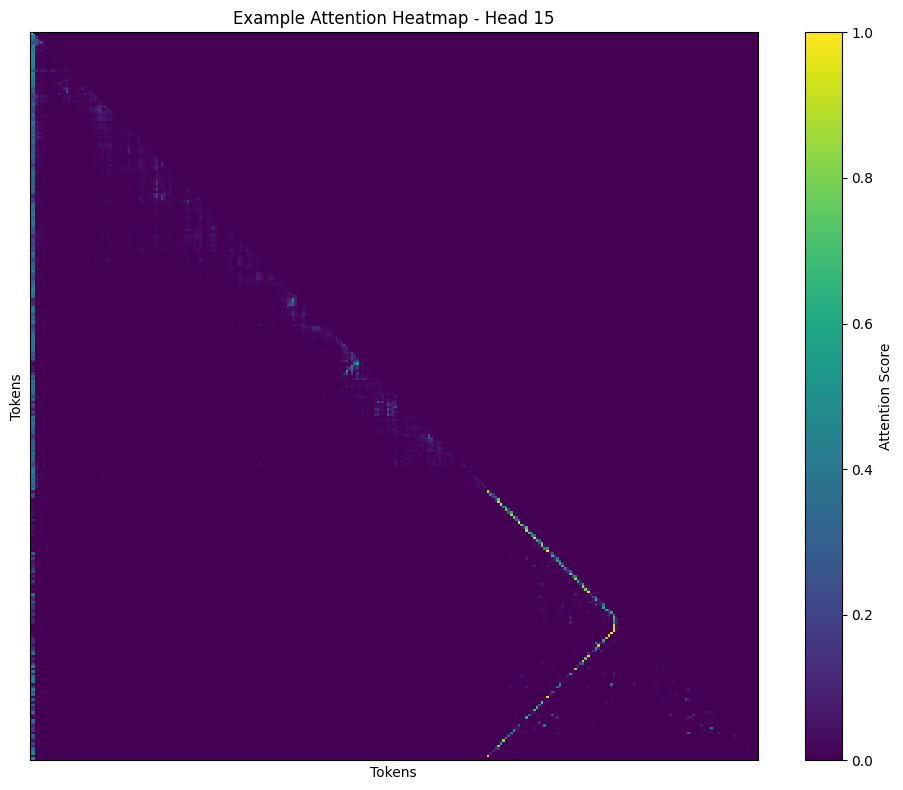

Loss: 0.5005056858062744, Accuracy: 90.20%
((12, 13),)


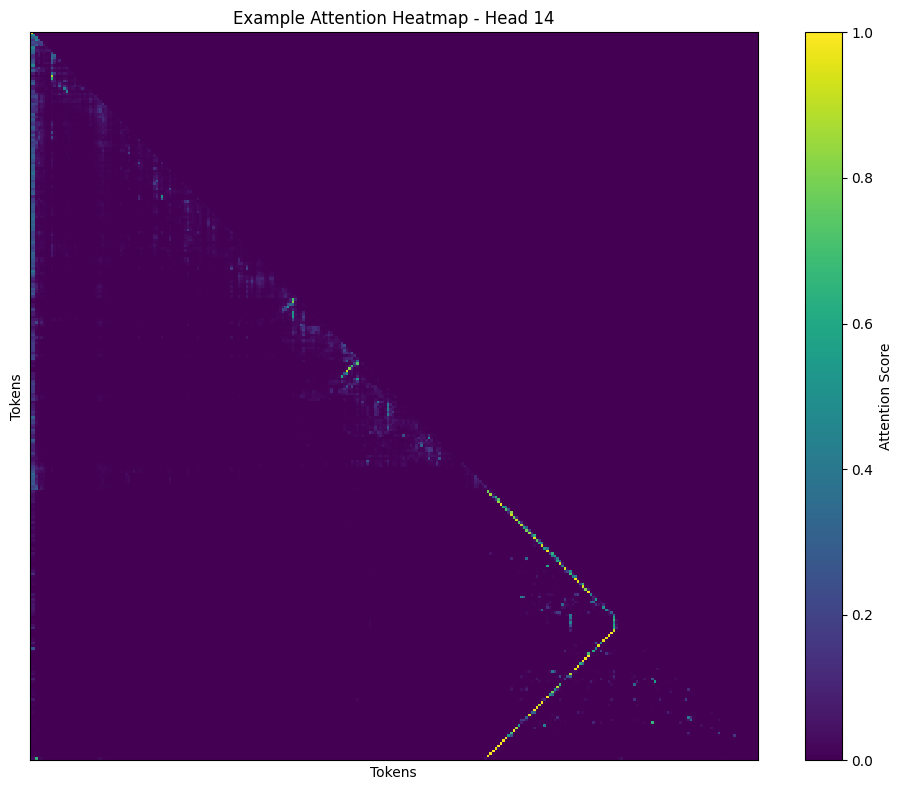

Loss: 0.5005056858062744, Accuracy: 90.20%
((14, 11),)


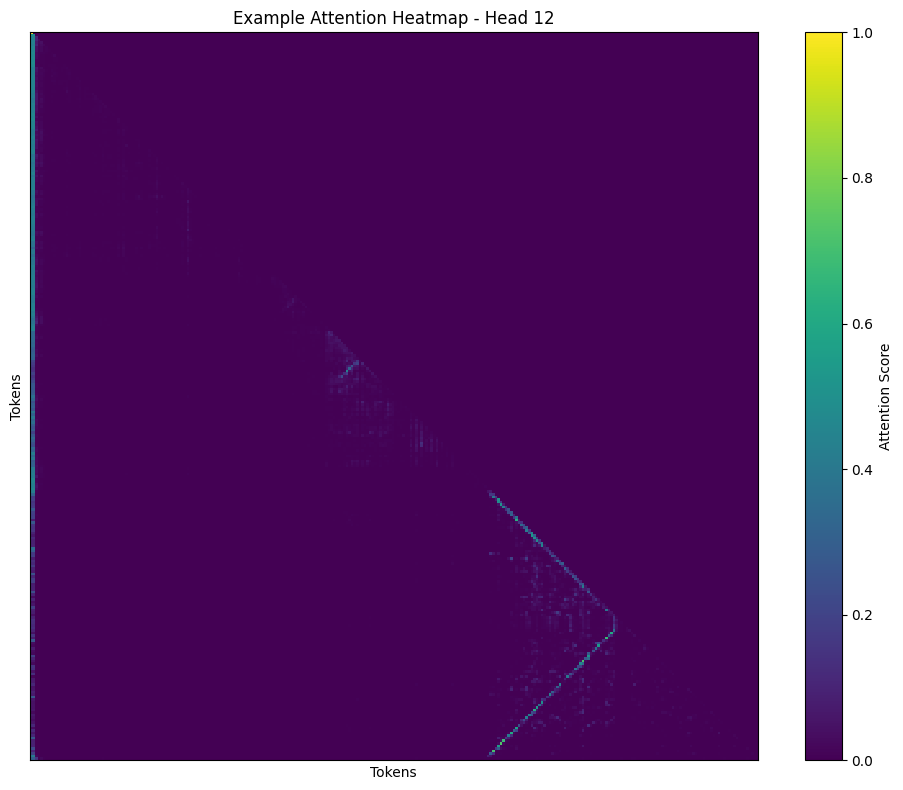

Loss: 0.5005056858062744, Accuracy: 90.20%
Moving model to device:  cuda
((11, 14),)


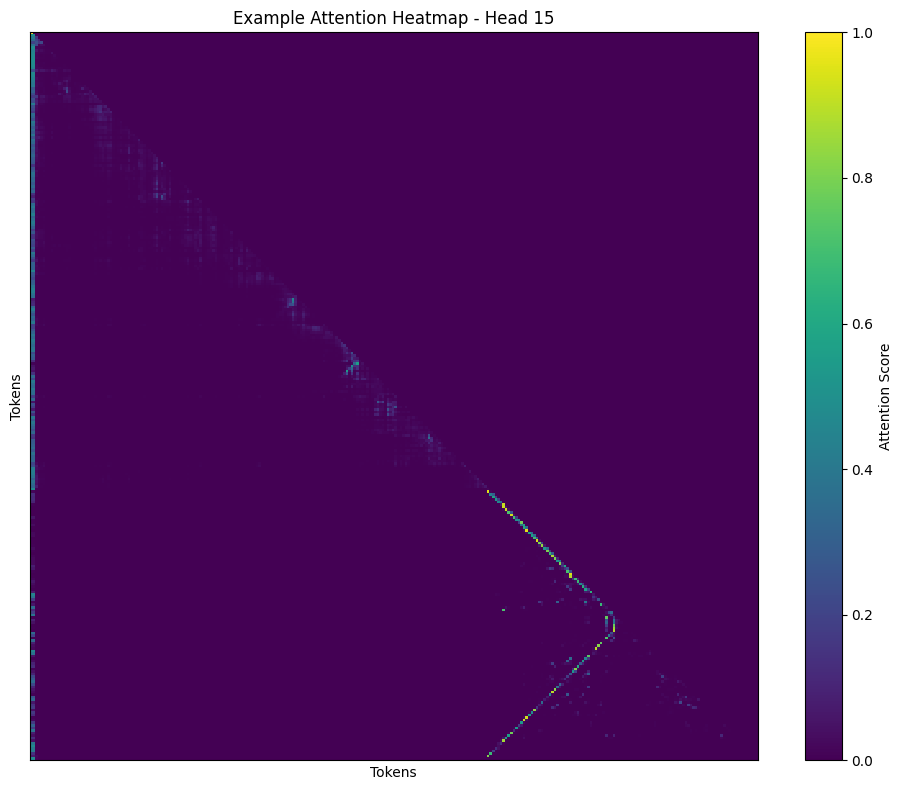

Loss: 0.23233045637607574, Accuracy: 88.24%
((12, 13),)


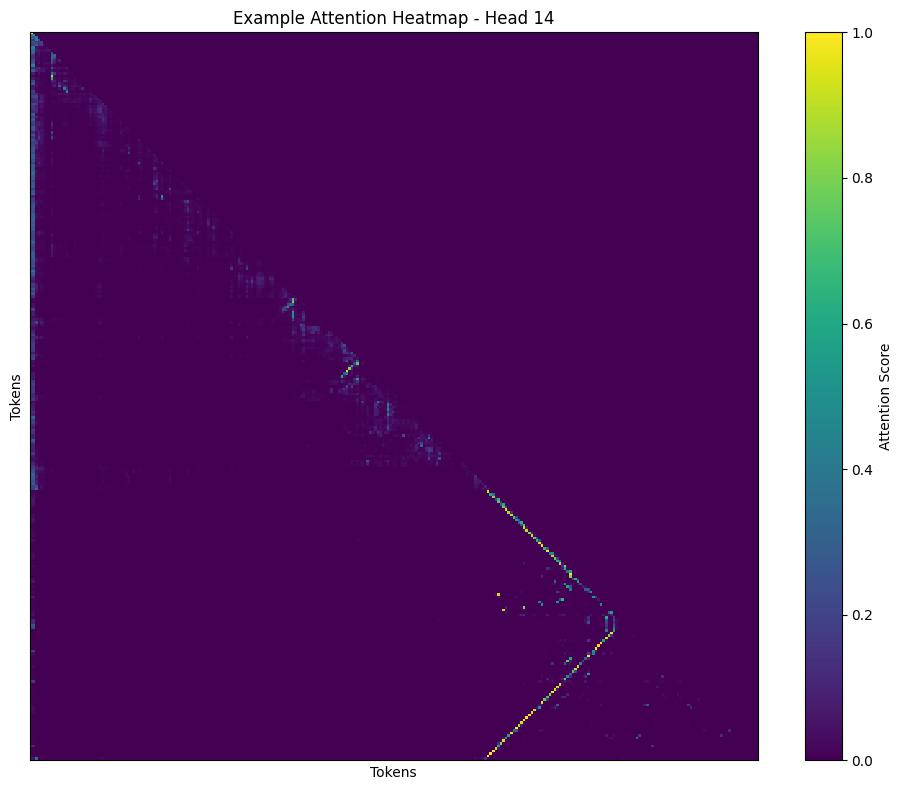

Loss: 0.23233045637607574, Accuracy: 88.24%
((14, 11),)


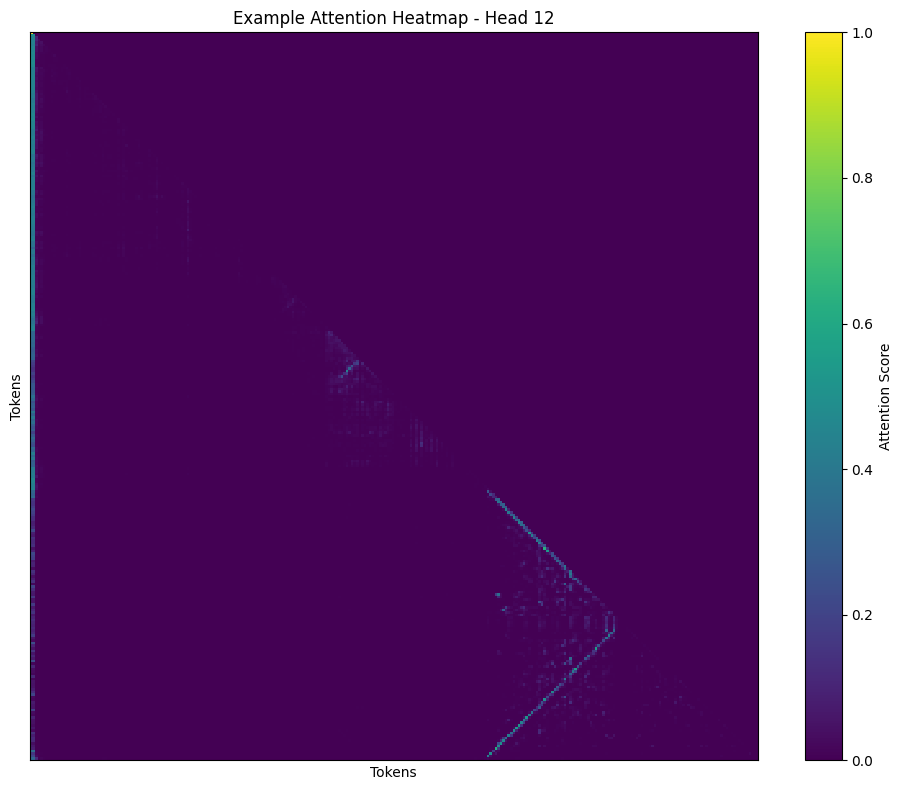

Loss: 0.23233045637607574, Accuracy: 88.24%
Moving model to device:  cuda
((11, 14),)


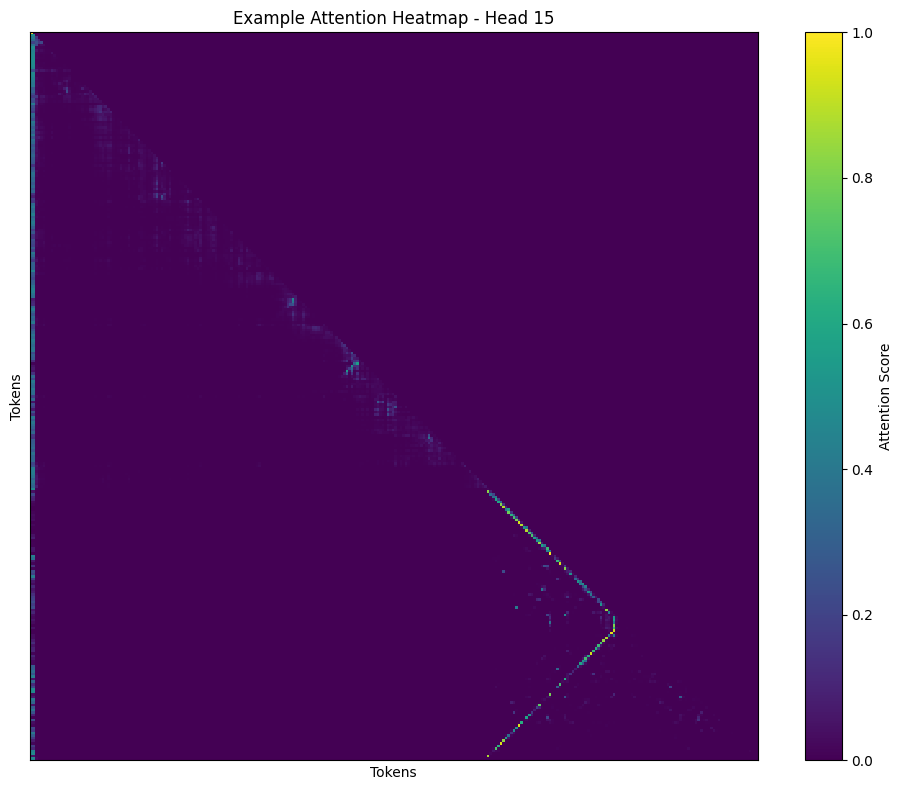

Loss: 0.27866852283477783, Accuracy: 96.08%
((12, 13),)


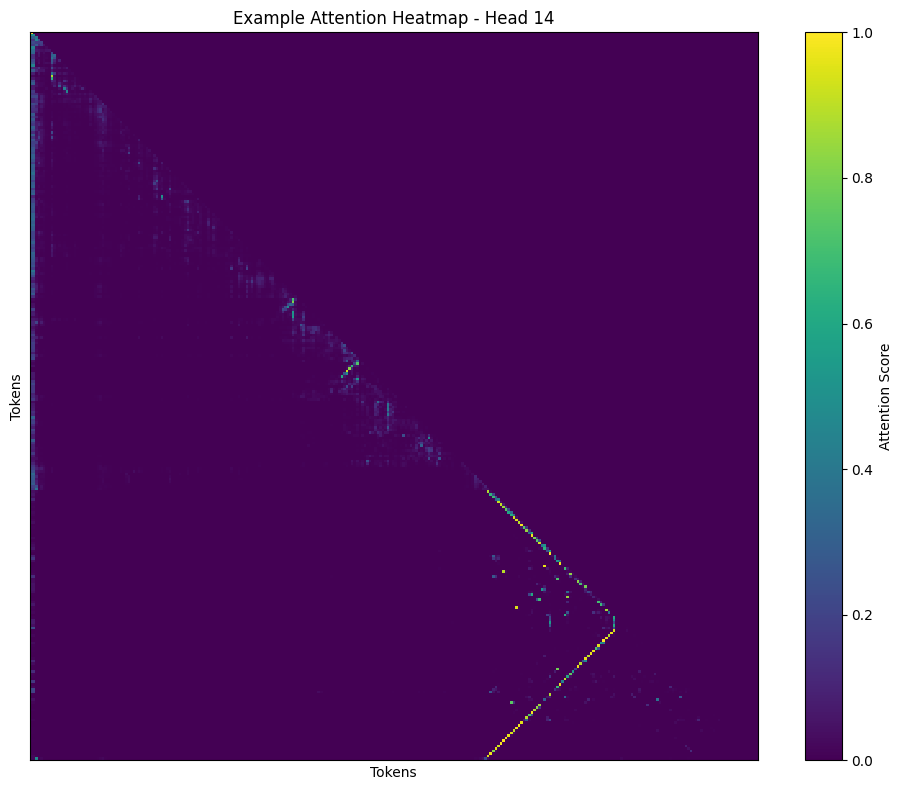

Loss: 0.27866852283477783, Accuracy: 96.08%
((14, 11),)


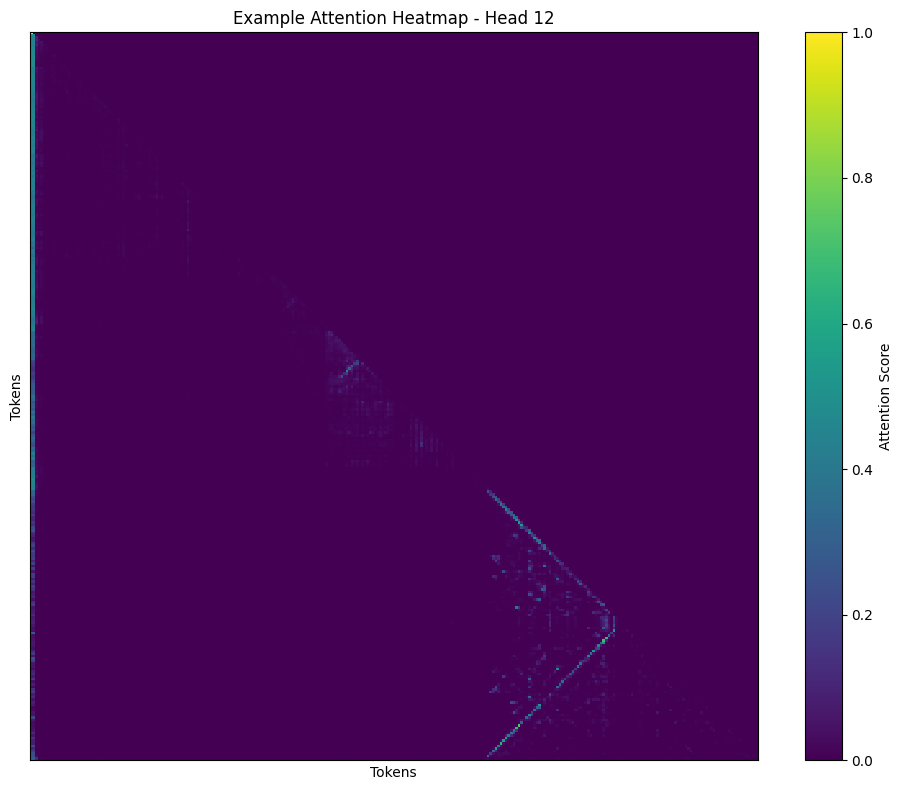

Loss: 0.27866852283477783, Accuracy: 96.08%
Moving model to device:  cuda
((11, 14),)


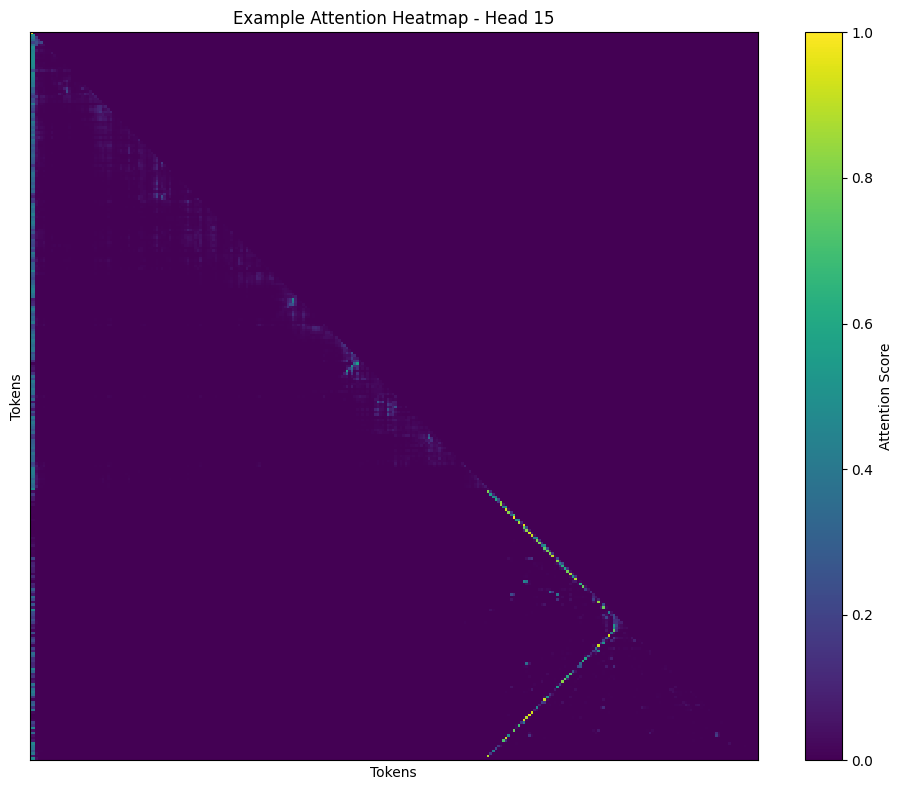

Loss: 0.26669400930404663, Accuracy: 96.08%
((12, 13),)


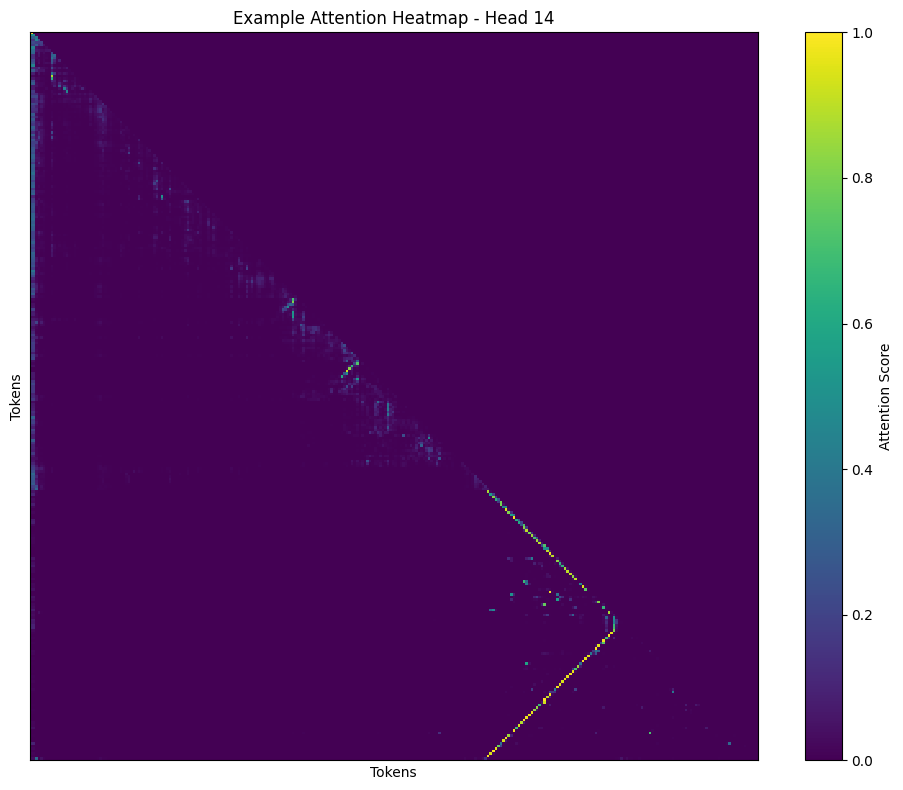

Loss: 0.26669400930404663, Accuracy: 96.08%
((14, 11),)


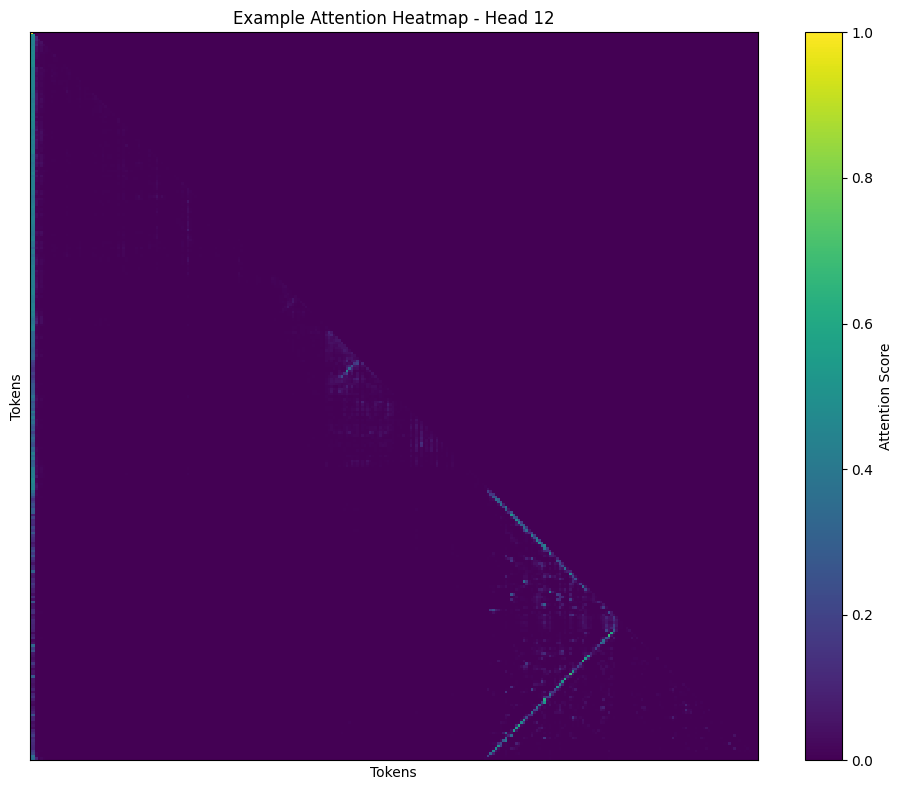

Loss: 0.26669400930404663, Accuracy: 96.08%
Moving model to device:  cuda
((11, 14),)


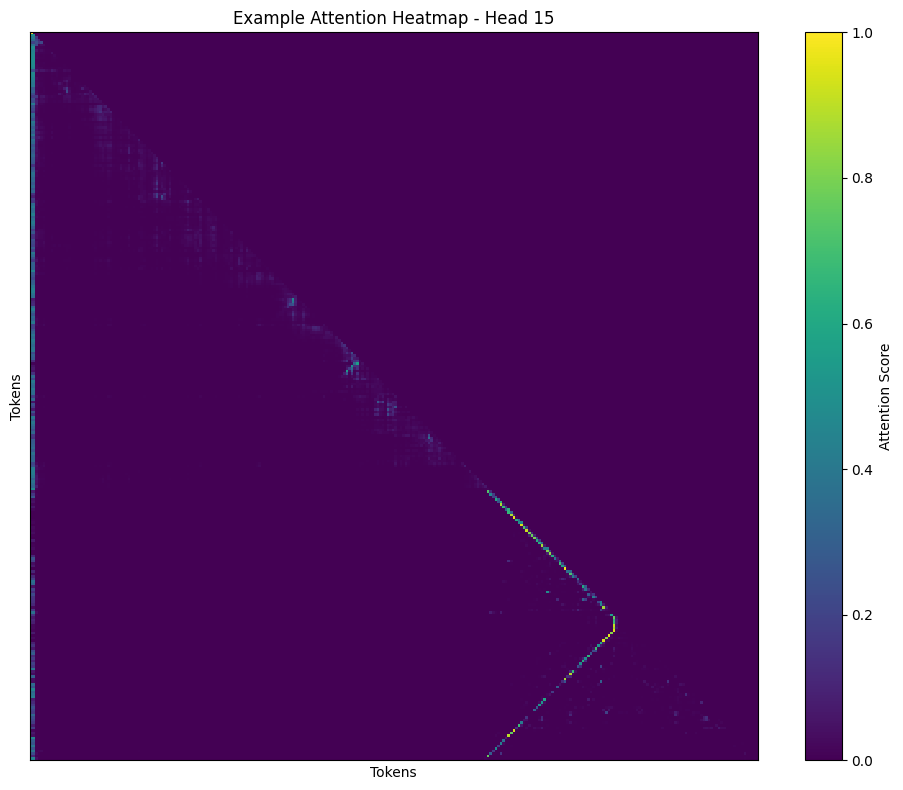

Loss: 0.48463529348373413, Accuracy: 92.16%
((12, 13),)


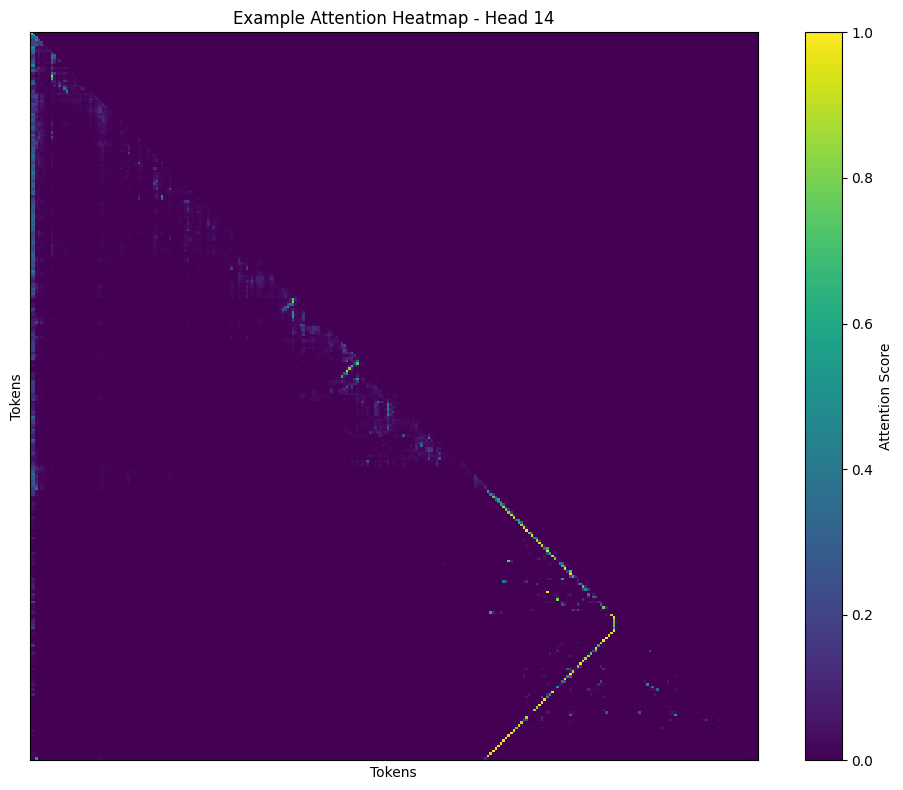

Loss: 0.48463529348373413, Accuracy: 92.16%
((14, 11),)


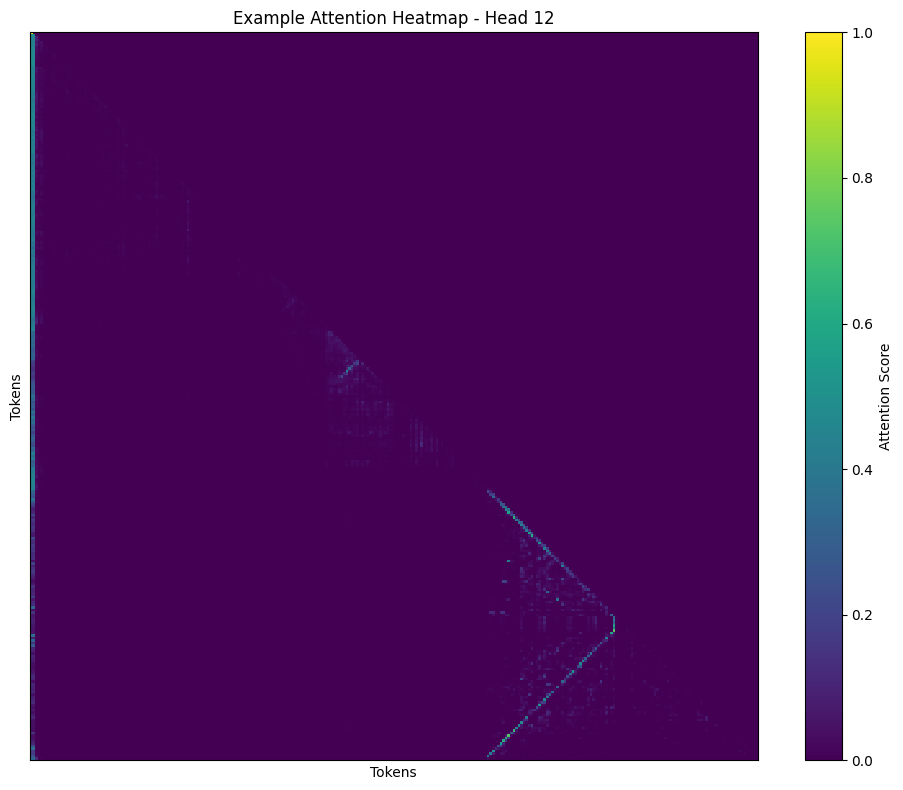

Loss: 0.48463529348373413, Accuracy: 92.16%
Moving model to device:  cuda
((11, 14),)


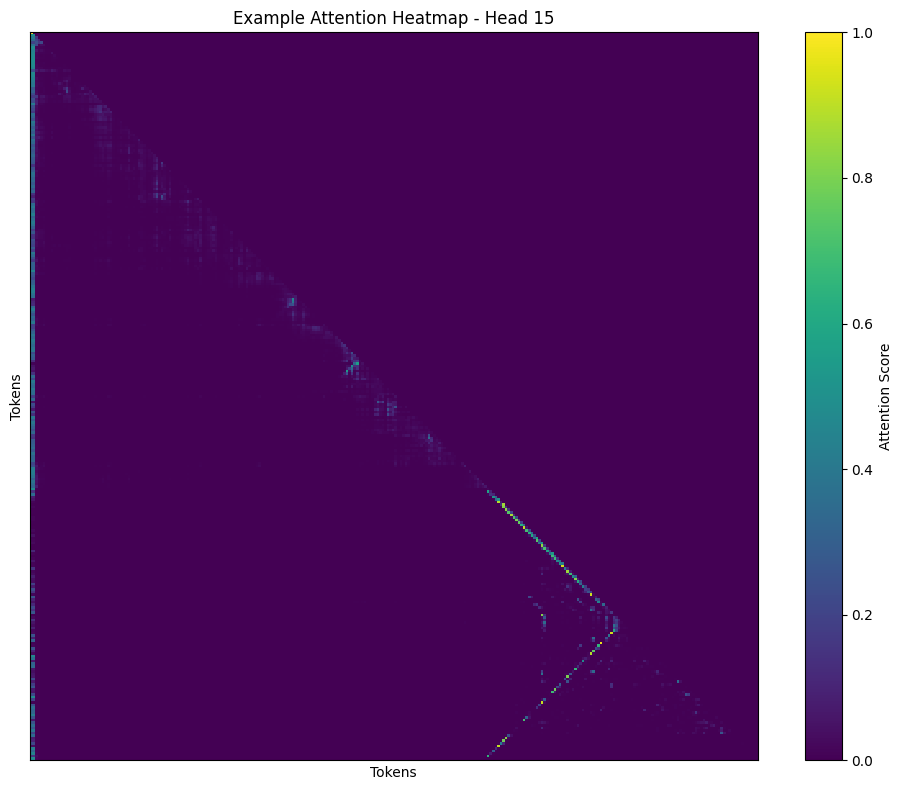

Loss: 1.4463540315628052, Accuracy: 76.47%
((12, 13),)


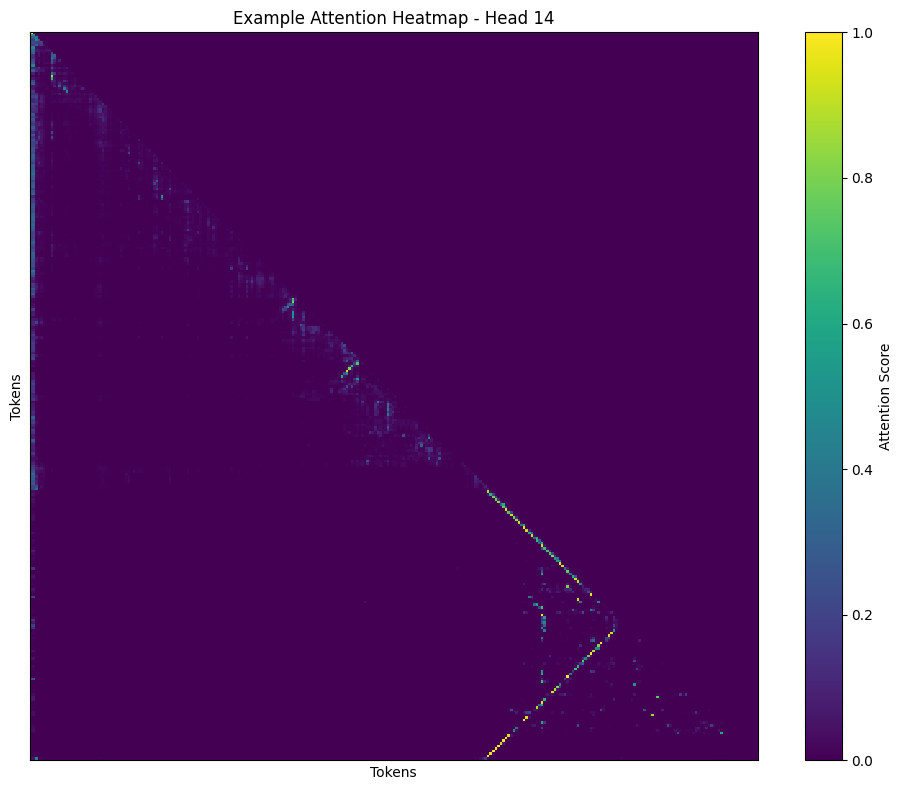

Loss: 1.4463540315628052, Accuracy: 76.47%
((14, 11),)


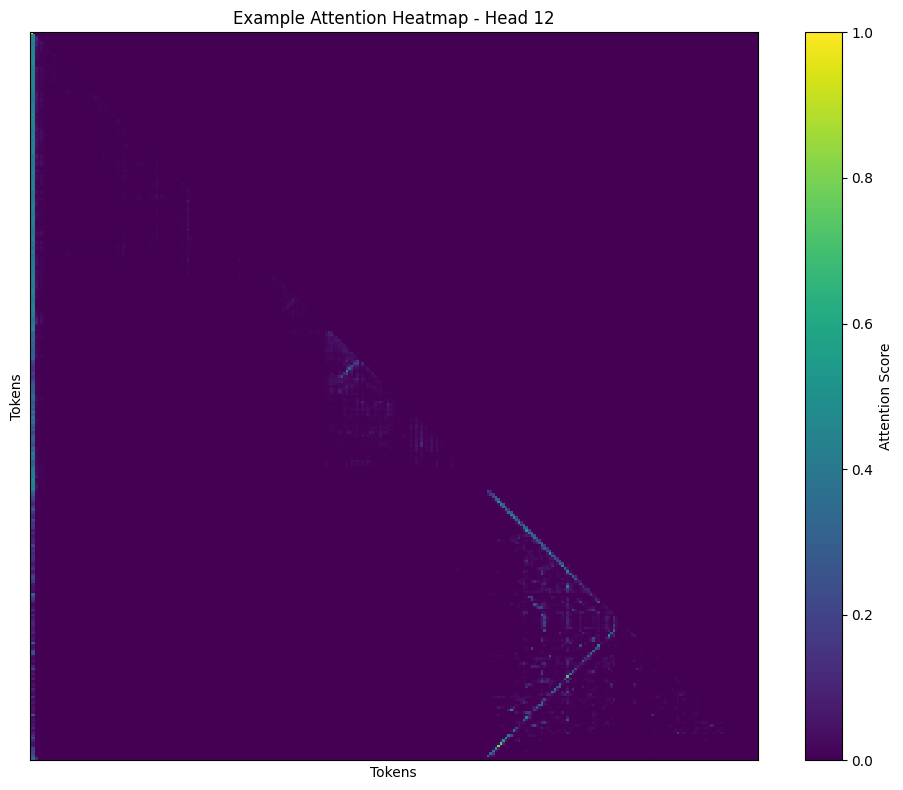

Loss: 1.4463540315628052, Accuracy: 76.47%
Moving model to device:  cuda
((11, 14),)


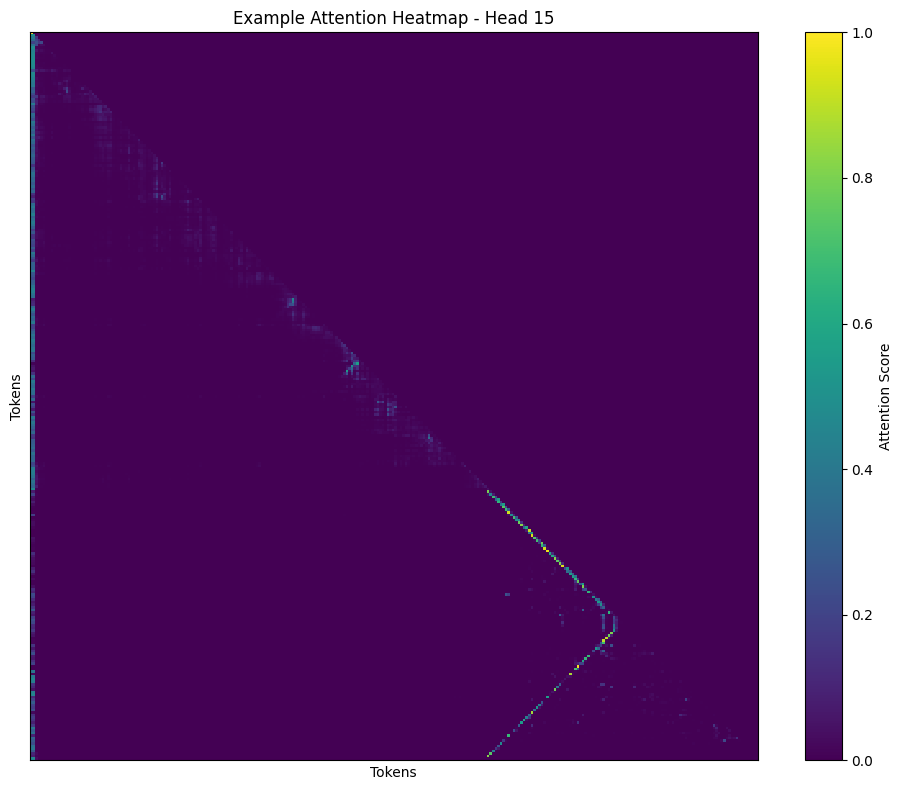

Loss: 0.4915641248226166, Accuracy: 94.12%
((12, 13),)


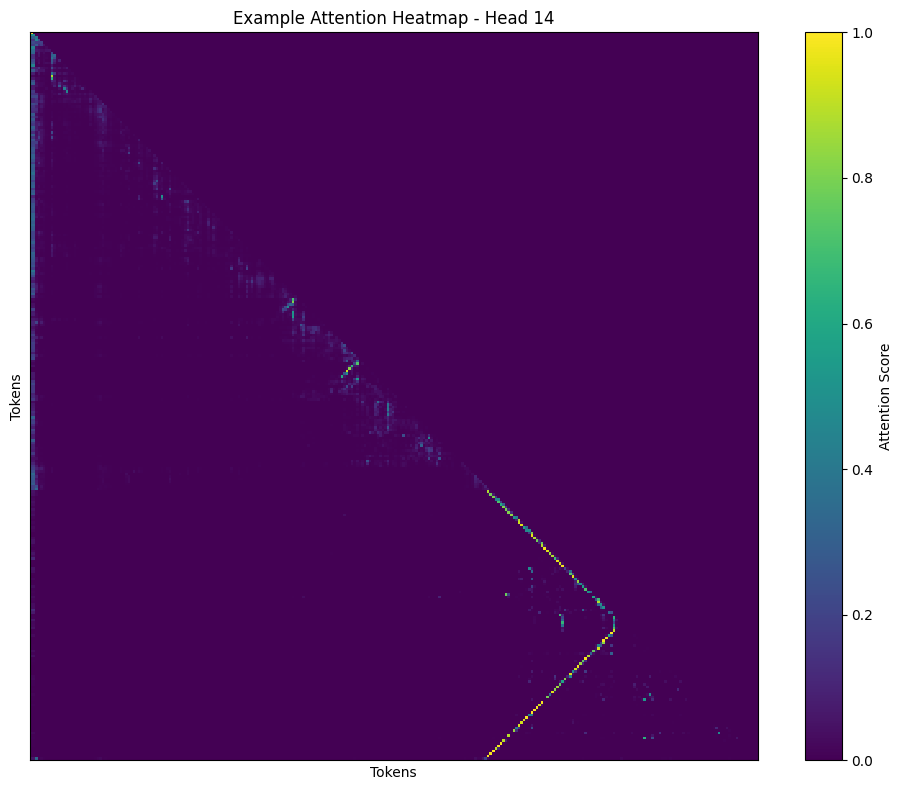

Loss: 0.4915641248226166, Accuracy: 94.12%
((14, 11),)


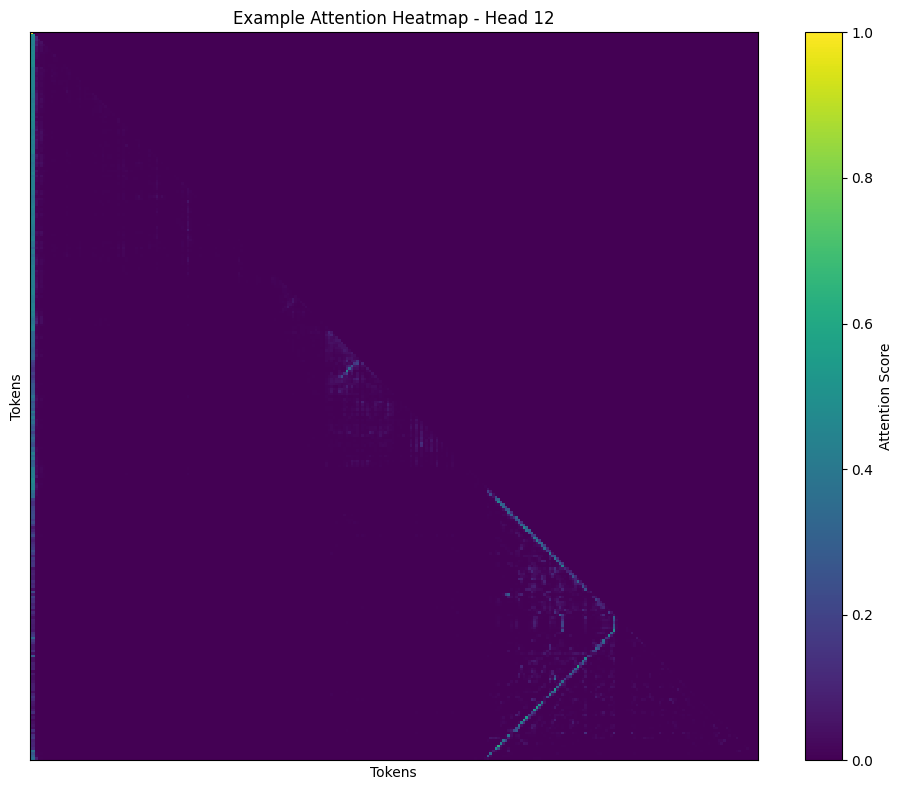

Loss: 0.4915641248226166, Accuracy: 94.12%
Moving model to device:  cuda
((11, 14),)


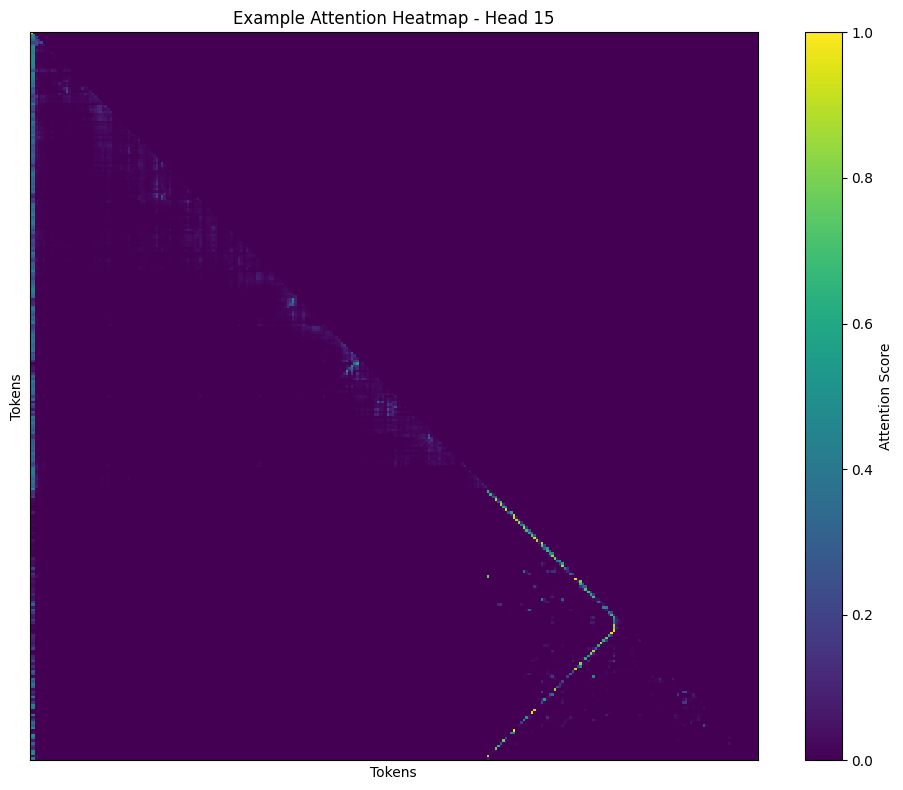

Loss: 0.6972159743309021, Accuracy: 88.24%
((12, 13),)


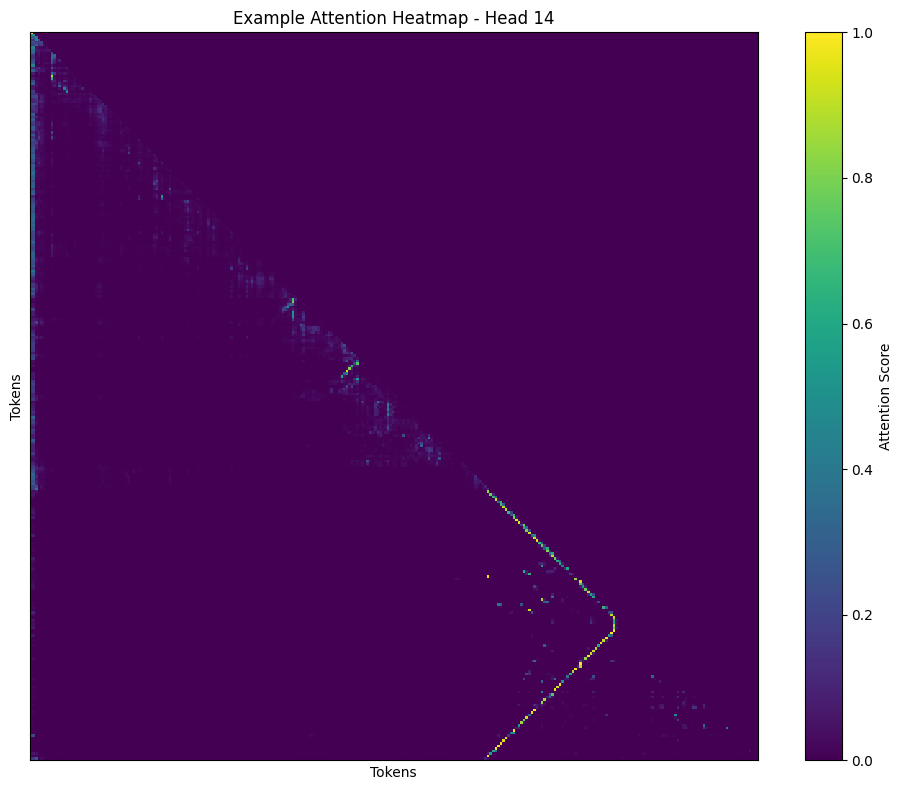

Loss: 0.6972159743309021, Accuracy: 88.24%
((14, 11),)


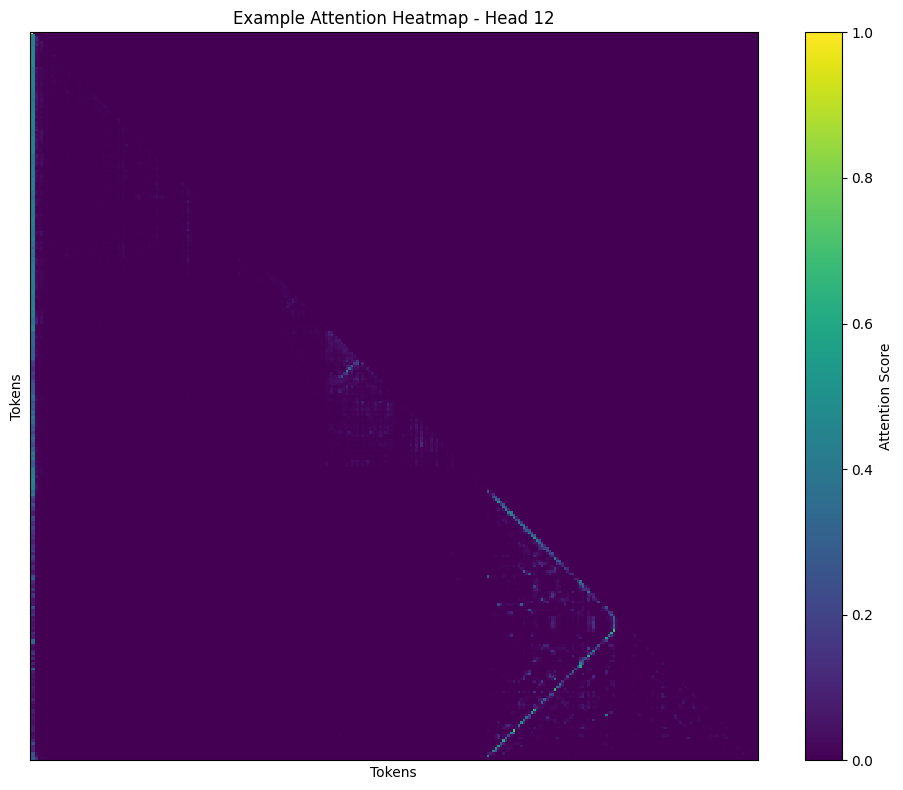

Loss: 0.6972159743309021, Accuracy: 88.24%
Moving model to device:  cuda
((11, 14),)


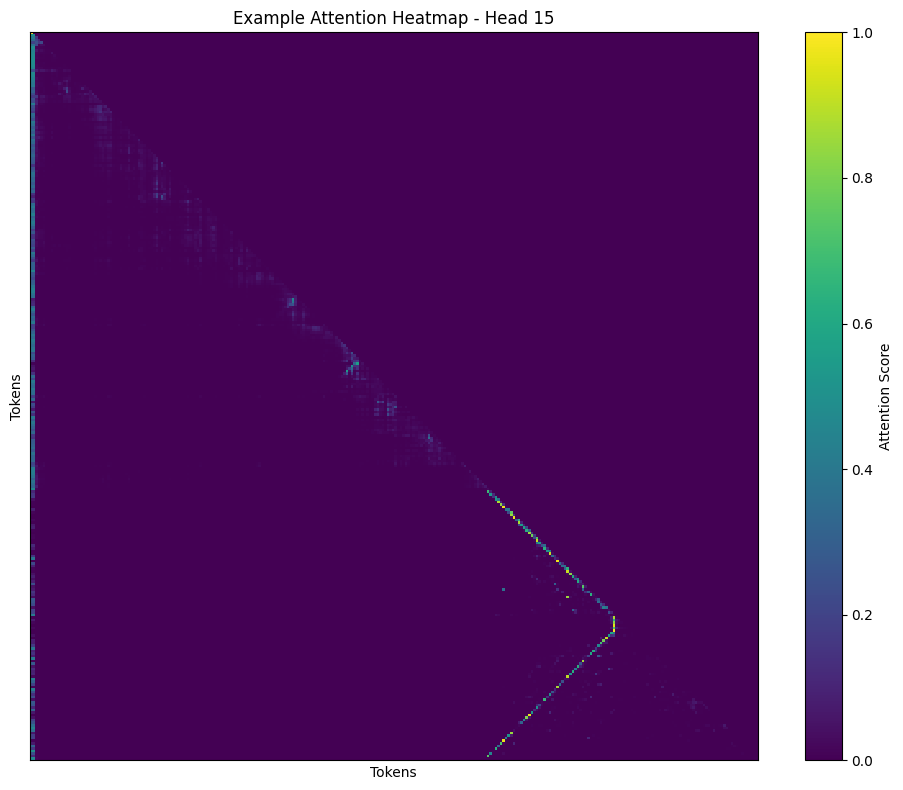

Loss: 0.015877874568104744, Accuracy: 100.00%
((12, 13),)


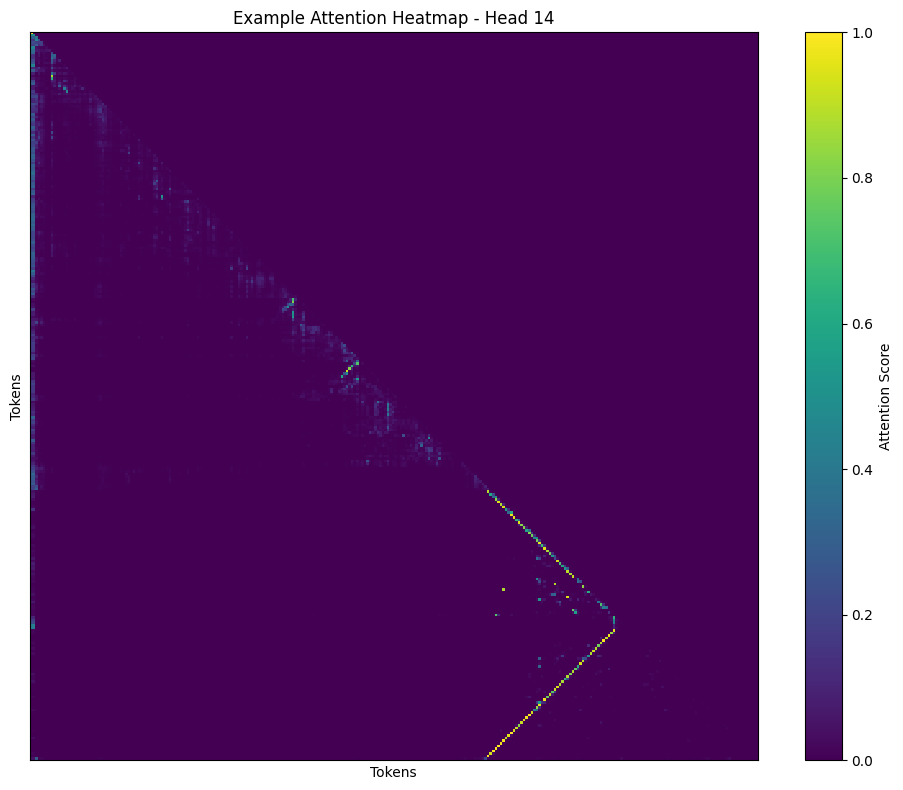

Loss: 0.015877874568104744, Accuracy: 100.00%
((14, 11),)


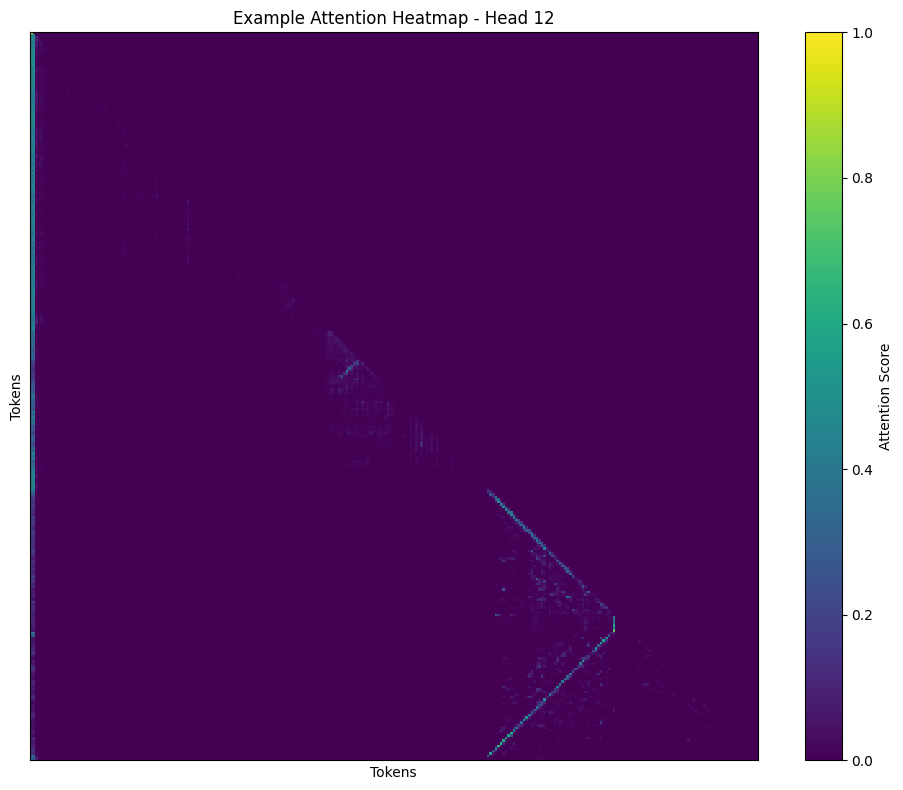

Loss: 0.015877874568104744, Accuracy: 100.00%
Moving model to device:  cuda
((11, 14),)


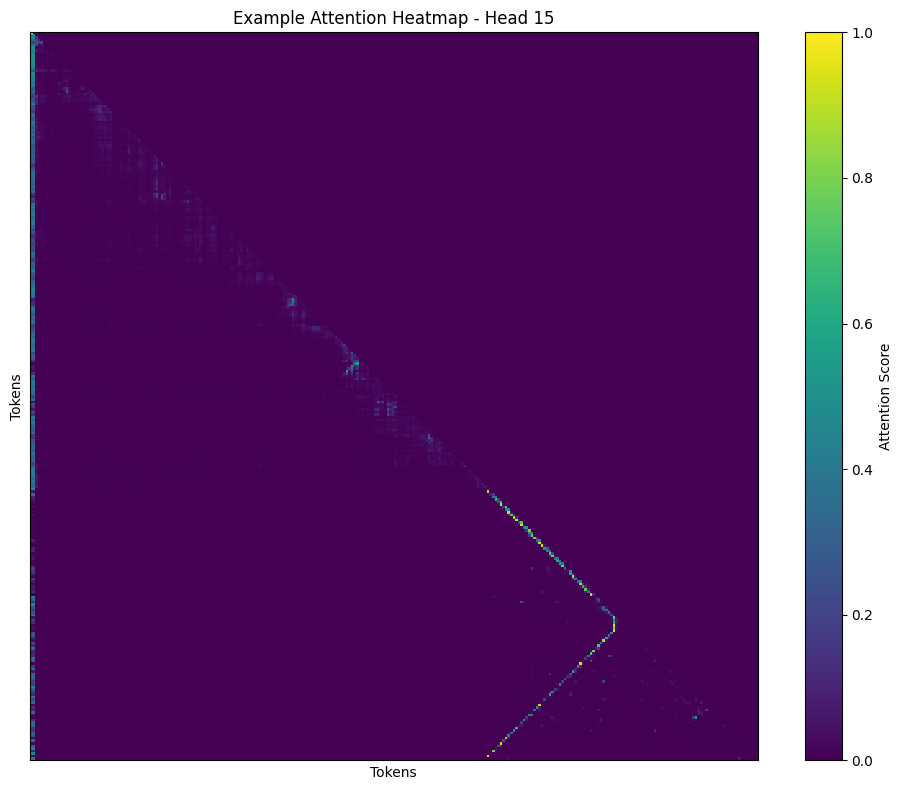

Loss: 0.30150237679481506, Accuracy: 90.20%
((12, 13),)


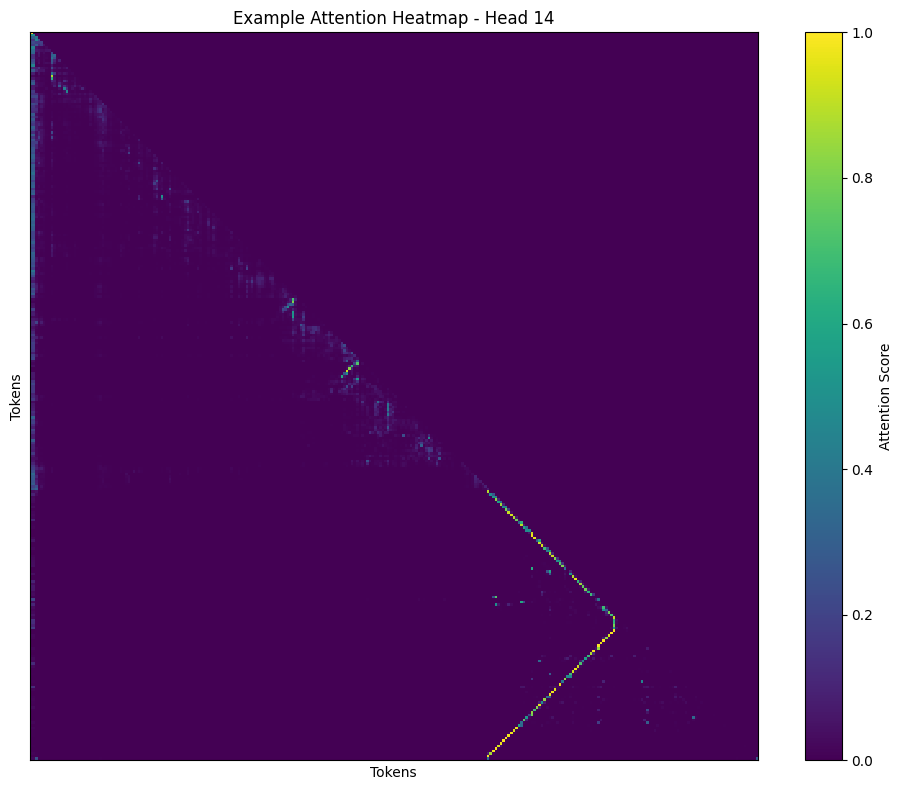

Loss: 0.30150237679481506, Accuracy: 90.20%
((14, 11),)


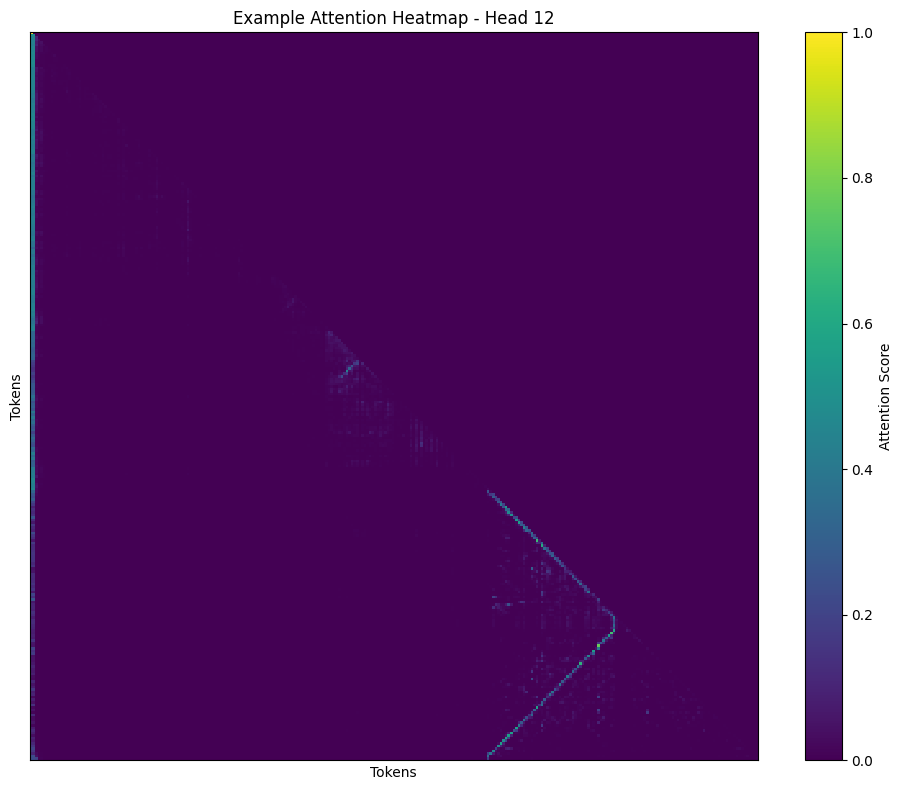

Loss: 0.30150237679481506, Accuracy: 90.20%


In [47]:
def compute_scores(logits, target):
    ignore_index = -100  # Optional: index to ignore in loss/accuracy computation
    # Compute loss
    loss = torch.nn.functional.cross_entropy(
    logits.view(-1, logits.size(-1)),  # Flatten logits to (batch_size * seq_len, vocab_size)
    target.view(-1),               # Flatten target_ids to (batch_size * seq_len)
    ignore_index=ignore_index          # Ignore padding tokens if applicable
)

    # Compute accuracy
    predictions = torch.argmax(logits, dim=-1)  # Get predicted token indices
    correct = (predictions == target) & (target != ignore_index)  # Ignore padding tokens
    accuracy = correct.sum().item() / (target != ignore_index).sum().item()

    print(f"Loss: {loss.item()}, Accuracy: {accuracy:.2%}")

    errors = (predictions != target) & (target != ignore_index)  # Identify error positions
    errors_np = errors.cpu().numpy()  # Convert to NumPy for visualization
    #print("Errors:", errors_np)

    return loss.item(), accuracy

def fix_attn_pattern_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    attn_labels_1_idx,
    heads_to_reinforce
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    #value[:, :, :, :] += torch.tensor(neco, dtype=torch.float32).cuda()
    batch, heads, seq_len, _ = value.shape 
    
    layer = int(hook.name.split(".")[1])
    if layer not in heads_to_reinforce.keys():
        return
    for h in range(heads):
        if h != heads_to_reinforce[layer]:
            continue
        visualize_attention_heads(value, None, title="Example Attention Heatmap", heads=[heads_to_reinforce[layer]])
        for i in range(seq_len):
            for j in range(seq_len):
                if (i, j) in attn_labels_1_idx:
                    #value[0, h, i, j] += 1
                    pass
        #print("After corrections")
        #visualize_attention_heads(value, None, title="Example Attention Heatmap", heads=[heads_to_reinforce[layer]])

    return value

device = "cuda"

is_attn_scores = lambda name: name.endswith("hook_pattern")

for idx in range(0, 10):

    model.to(device)
    input_ids[idx] = input_ids[idx].to(device)
    target_ids[idx] = target_ids[idx].to(device)
    attn_labels[idx] = attn_labels[idx].to(device)

    attn_labels_1_idx = set()
    for i in range(len(attn_labels[idx])):
        for j in range(len(attn_labels[idx][0])):
            if attn_labels[idx][i][j] == 1:
                attn_labels_1_idx.add((i, j))

    heads_to_reinforce=[
        (11, 14),
        (12, 13),
        (14, 11),


    ]
    import random
    import itertools
    cols_to_keep = ~np.all(attn_labels[idx].cpu().numpy() == -100, axis=0)
    ablated = []
    for i in range(1,2):
        for heads in itertools.combinations(heads_to_reinforce, i):
            print(heads)
            heads = dict(heads)
            logits = model.run_with_hooks(input_ids[idx], return_type="logits",
                                            fwd_hooks=[
                                                (is_attn_scores, partial(fix_attn_pattern_hook, attn_labels_1_idx=attn_labels_1_idx, heads_to_reinforce=heads))
                                            ])
            loss, acc = compute_scores(logits, target_ids[idx])
            ablated.append((heads, loss, acc))
            del logits
            torch.cuda.empty_cache()
    

In [37]:
noise[0][0]

NameError: name 'noise' is not defined

In [ ]:
noise[0, 0, 210:, 210:]

NameError: name 'noise' is not defined